## Phase 3 Project
### H1N1 and Seasonal flu vaccines

# 1. Introduction <a id="intro"></a> 

> The Objective is to perform a multilabel classification of whether a person will/will not take the:
  >  1. H1N1 vaccine 
  >  2. Seasonal Flu vaccine

In [87]:
### Necessary imports ###

import numpy as np # linear algebra
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier as RF
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble 
from sklearn import discriminant_analysis, gaussian_process

# 2. Preliminary analysis & Data Processing <a id="prelim"></a> 

Reading the data

In [3]:
X = pd.read_csv('training_set_features.csv')
Y = pd.read_csv('training_set_labels.csv')

In [4]:
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

Shape of X:  (26707, 36)
Shape of Y:  (26707, 3)


> We see that there are 36 columns/features in the training set 

> There are 3 columns in the target file(ground truth) which include respondent_id, h1n1_vaccine,seasonal_vaccine

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
X.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


Several features including a persons 'behavior' and his/her 'opinion' about the vaccine, marital status, geographic location all are found, so the data consists a significantly large amount of info

In [7]:
X.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [8]:
### Joining the X & Y into a single dataframe ###
Z = Y
Z.drop('respondent_id',axis = 1,inplace = True)
frames = [X,Z]
data = pd.concat(frames,axis=1)

Checking out the number of NULLs/NaNs

In [9]:
data.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

Columns **'health_insurance', 'employment_industry' , 'employment_occupation'** contain too many NULLs

In [11]:
# close to half the values of these columns are NULL so discarding
data.drop(['health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

# 3. Exploratory Data Analysis and Visualizations <a id="eda"></a> 

### Firstly Analyzing the number of people who took each vaccine

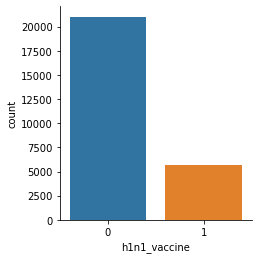

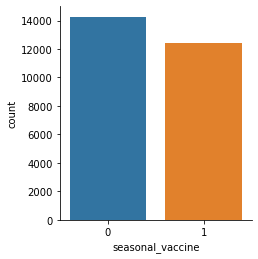

In [10]:
sns.factorplot('h1n1_vaccine',data=Y,kind='count',size = 3.5)
sns.factorplot('seasonal_vaccine',data=Y,kind='count',size = 3.5)

Considerably larger number of people have chosen to take the seasonal flu vaccine compared to those who took the H1N1 vaccine

### Next Finding the categorical features present in the data 

In [12]:
str_cols = data.select_dtypes(include = 'object').columns
data[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


There are 10 categorical features

### Populating the NULLs/NaNs with suitable substitutes

P.S: All Categorical features which are NULL are substituted with the mode of data, and the Numeric features with NULLs are substituted with the means

In [13]:
# All the NULL values are populated with the mode
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes != 'object':
        data[col].loc[(X[col].isnull())] = data[col].median()
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes == 'object':
        data[col].loc[(data[col].isnull())] = data[col].mode().max()

Sanity Check below

In [14]:
data.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

### Categorical Features are encoded using Label Encodings

P.S: Please consider trying out Mean Encodings, One Hot Encoding or Ordinal Encodings and notice the differences

In [15]:
LE = LabelEncoder()
for col in str_cols:
    data[col] = LE.fit_transform(data[col]) # Converts to int64

Sanity Check again!

In [16]:
data[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,3,1,3,0,2,1,0,1,8,2
1,1,0,3,1,2,1,1,0,1,0
2,0,2,3,1,0,1,0,0,9,0
3,4,0,3,0,2,1,1,1,5,1
4,2,3,3,0,0,0,0,0,9,0


### Plotting Correlation Maps with the set of Encoded and Null Populated Features

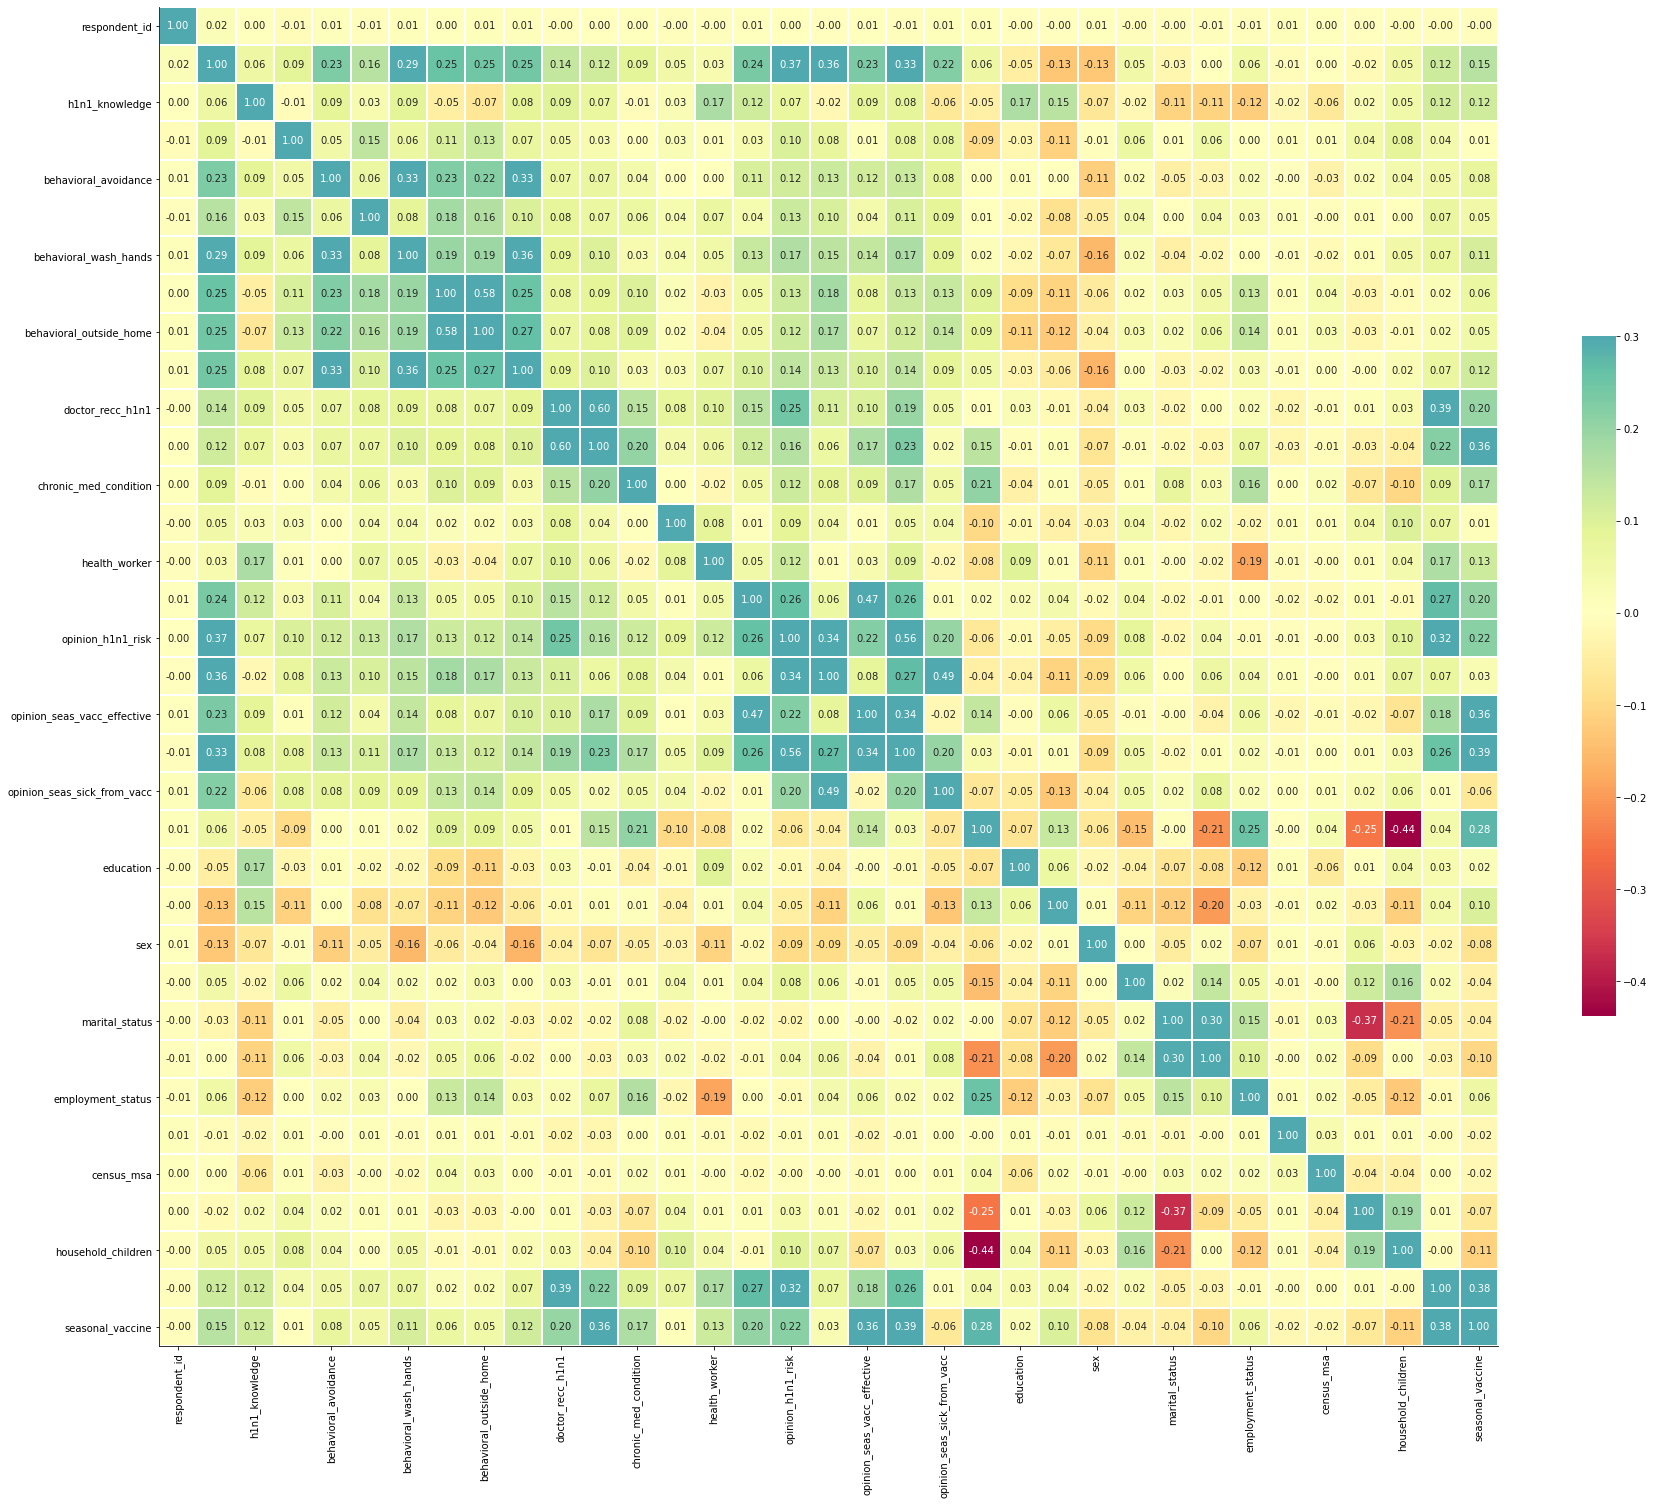

In [17]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

*  High Positive correlations between the 'behavioral_features' is noted, some of them may be redundant.
 
*  High Positive Correlations between opinion of h1n1 risk, doctor recommendation of vaccines Vs whether the person really took the vaccine. Seems fairly obvious

*  Overall the data features seems to be positively correlating with the act of taking the vaccination, except with some rare differences

* Can mainly notice that there are many redundant features/sparsely correlated features which should be taken care of.

### Now Plotting the Heatmap of all the Categorical features which were label encoded for a better idea

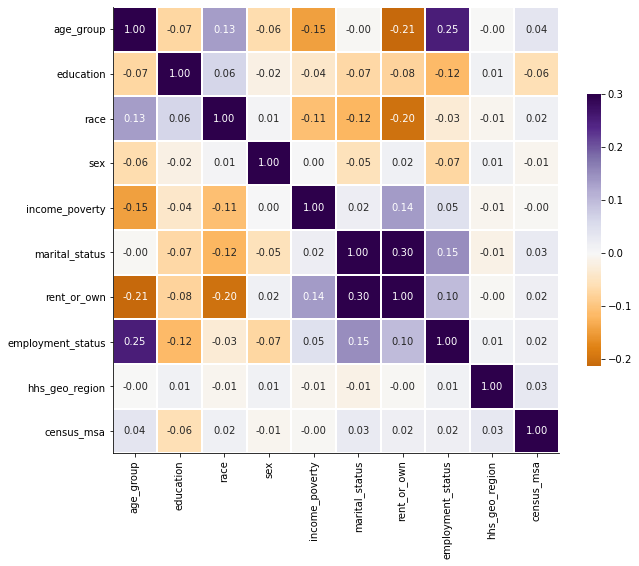

In [18]:
datum = data[str_cols]
corr = datum.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
g.figure.set_size_inches(10,10)
    
plt.show()

### Abundance of plots below!

* #### Pairwise Correlation plots of all the relevant and majorly significant features are given below. 
* #### Many features which are neutral and of no 'suggestive' value to the predictions should be removed later on to avoid redundancy.

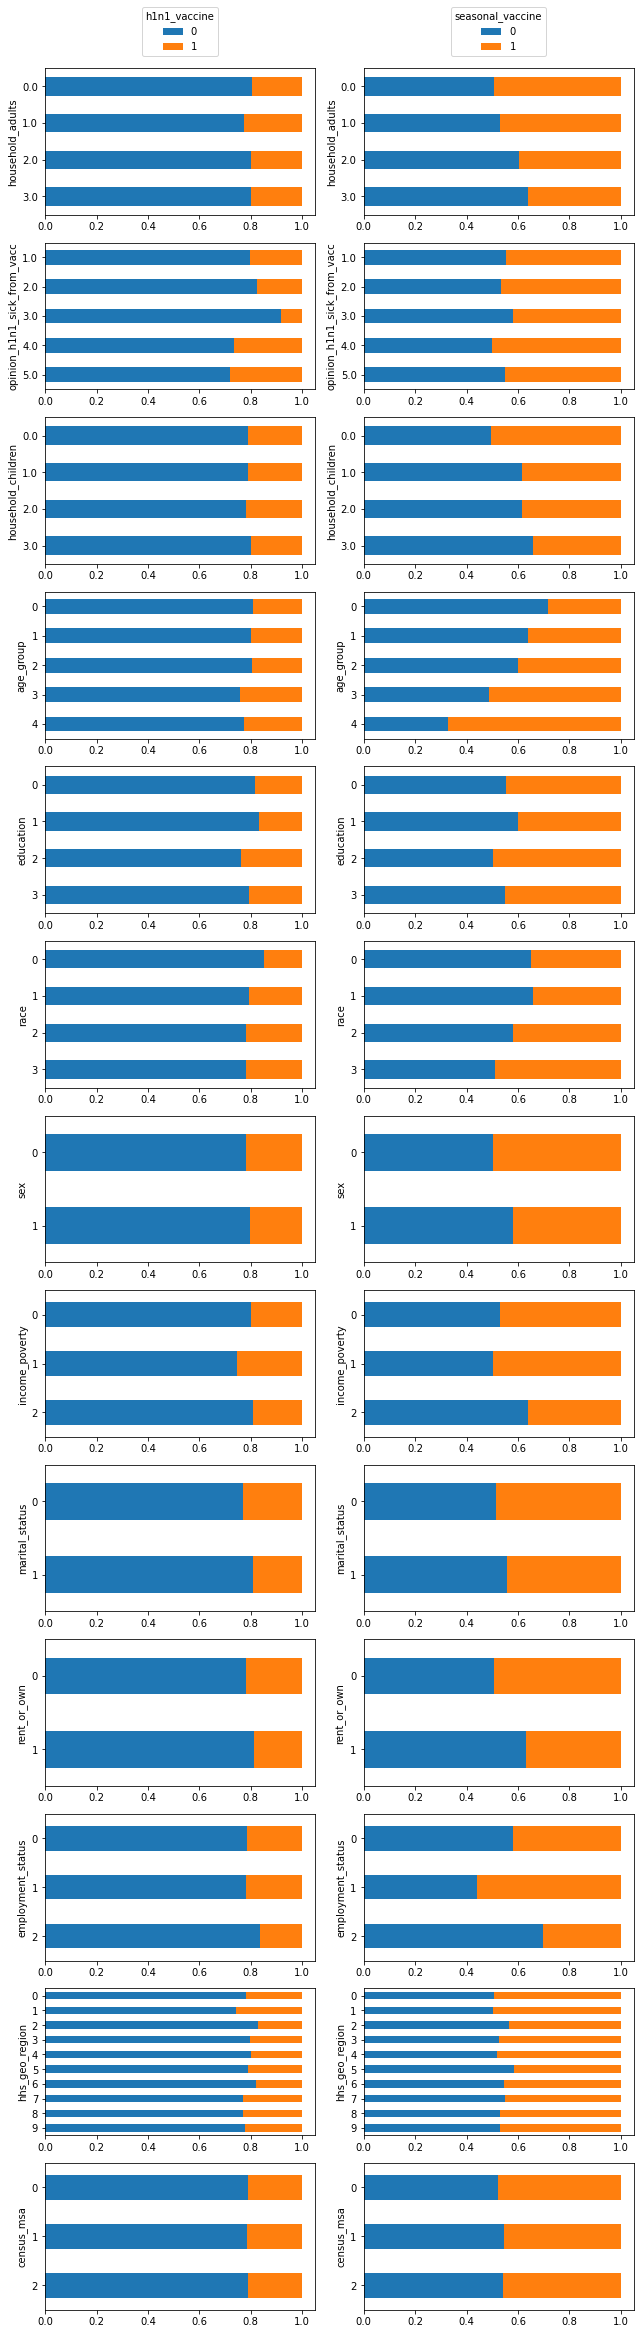

In [19]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = [
     'household_adults','opinion_h1n1_sick_from_vacc',
       'household_children', 'age_group', 'education', 'race',
       'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa'
       
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', data, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', data, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

* Census MSA, Race or Geographic Region don't seem to be suggestive and are kind of neutral. Might not be that helpful
* Employment status, Living on Rent and Marital Status maybe relevant for H1N1, but not as such for Seasonal
* Since there are a majority of people who have taken Seasonal compared to H1N1 vaccine, we might as well focus on the ones relevant to seasonal more, as there is a clearer distinction.

### More Plots


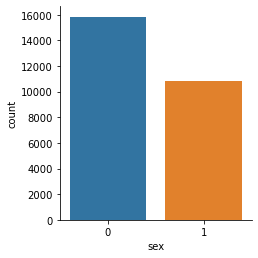

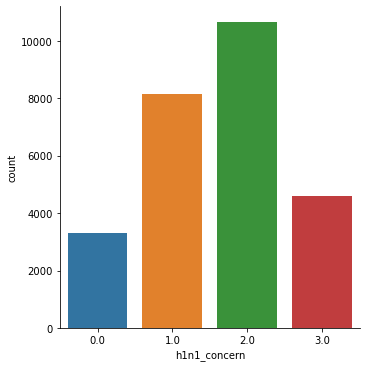

In [20]:
## The gender distribution of the data
sns.factorplot('sex',data=data,kind='count',size = 3.5)

## The number of people in each category of concern
sns.factorplot('h1n1_concern',kind = 'count',data = data)

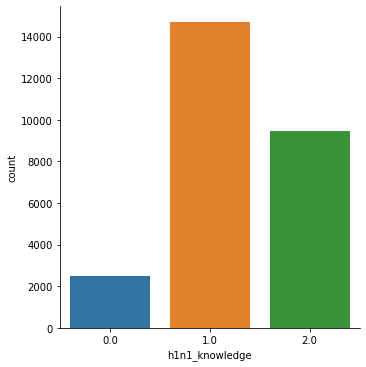

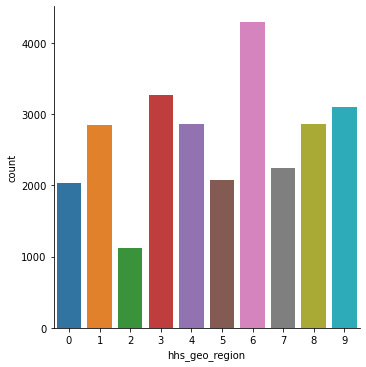

In [21]:
sns.factorplot('h1n1_knowledge',kind = 'count',data = data)
sns.factorplot('hhs_geo_region',kind = 'count',data = data)

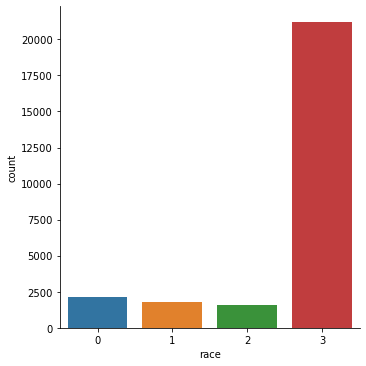

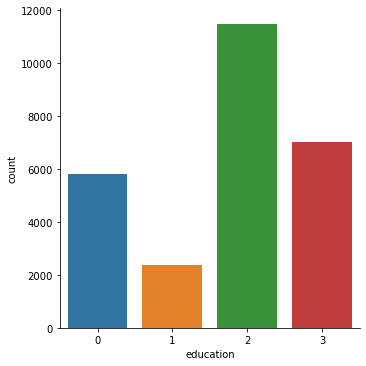

In [22]:
sns.factorplot('race',kind = 'count',data = data)
sns.factorplot('education',kind = 'count',data = data)

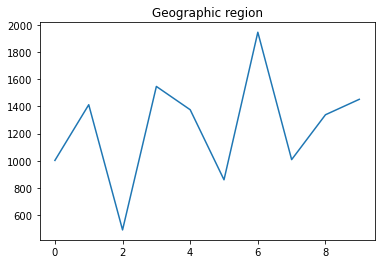

In [23]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['seasonal_vaccine'])
plt.show()
### people living in geographic regions 1,3,6 are more likely to get vaccinated than the rest

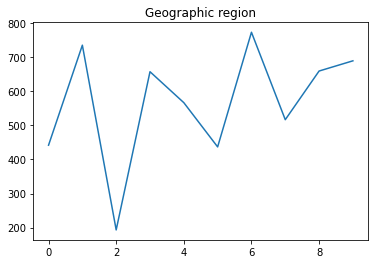

In [24]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['h1n1_vaccine'])
plt.show()

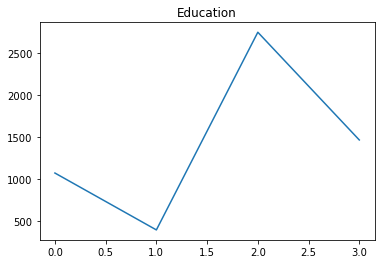

In [25]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['education']).sum()
plt.title('Education')
plt.plot(df['h1n1_vaccine'])
plt.show()

# 4. Feature Selection, Extraction & Engineering <a id="fe"></a> 

### Creating a new feature 'cleanliness' which combines the behaviour's

In [26]:
data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']

In [27]:
data['cleanliness']

0        2.0
1        4.0
2        1.0
3        3.0
4        4.0
        ... 
26702    2.0
26703    2.0
26704    5.0
26705    1.0
26706    1.0
Name: cleanliness, Length: 26707, dtype: float64

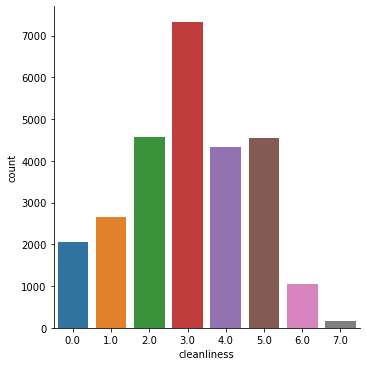

In [28]:
sns.factorplot('cleanliness',kind = 'count',data = data)

Checking the total number of people who have taken the H1N1 vaccine

In [29]:
print(data[data["h1n1_vaccine"]==1].count()[1])

5674


### Creating Plots for the new feature for each vaccine to check the correlation

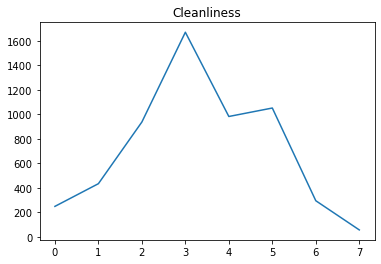

In [30]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['h1n1_vaccine'])
plt.show()

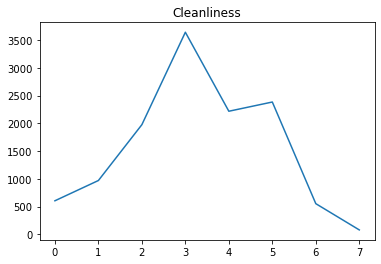

In [31]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['seasonal_vaccine'])
plt.show()

People with cleanliness 2 or above are more likely to get vaccinated than the rest

### Creating a new feature 'opinion' which combines the several 'opinion' columns

In [32]:
data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

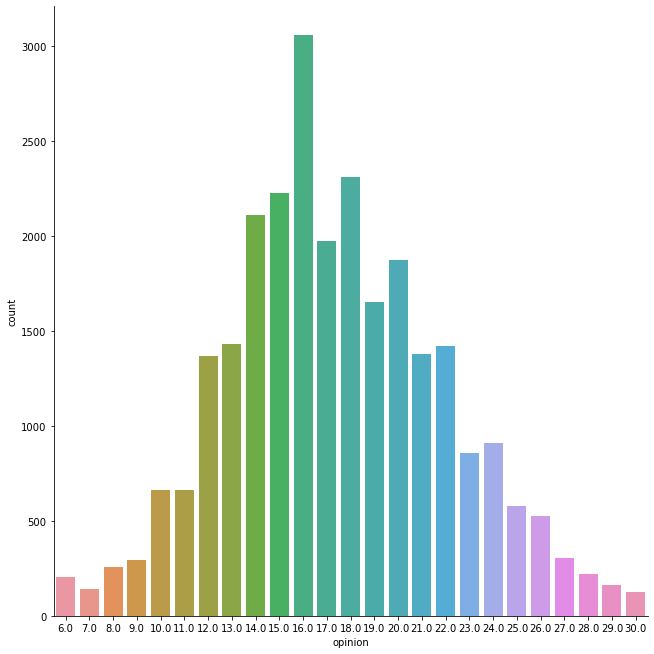

In [33]:
sns.factorplot('opinion',kind = 'count',data = data,size=9)

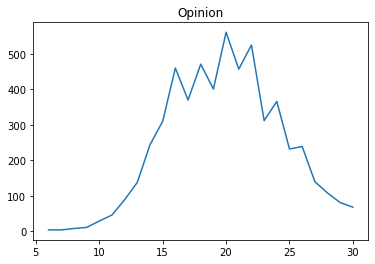

In [34]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['opinion']).sum()
plt.title('Opinion')
plt.plot(df['h1n1_vaccine'])
plt.show()

### Creating seperate opinions for both vaccine's

In [35]:
data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                  data['opinion_h1n1_sick_from_vacc'] 
data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

In [36]:
data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0) 
# Since those who have concern>=2 have a pronounced effect on vaccination

data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previously

In [37]:
data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)

#data['sick'] = np.where(data['opinion_h1n1_sick_from_vacc'] == 3,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations!

data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
data['a^2'] = data['age_group']*data['age_group']

### Checking everything out

In [38]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk', 'concern_knowledge', 'a^2'],
      dt

In [39]:
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,2.0,11.0,2.0,1.0,0,0,0,0,1.0,9
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,4.0,23.0,5.0,2.0,1,0,1,1,5.0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,3.0,3.0,0,0,0,0,2.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3.0,21.0,1.0,8.0,0,0,0,0,2.0,16
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,4.0,16.0,4.0,0.0,1,1,0,0,3.0,4


### Removing all the redundant, irrelevant and non-contributory features

In [40]:
##### Removing seemingly irrelevant features ######

data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)

Y_label = data[['h1n1_vaccine','seasonal_vaccine']]

### Whisker plots

Below plot indicates that there are few outliers and mostly similar distributions for doctor reccomendation (highly correlated feature) and opinion (an engineered feature).

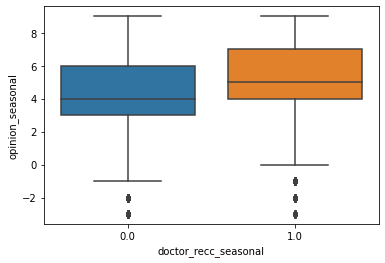

In [41]:
ax = sns.boxplot(x="doctor_recc_seasonal", y="opinion_seasonal", data=data)

cleanliness (an engineered feature) vs the 'opinion seasonal' ( highly correlated feature)

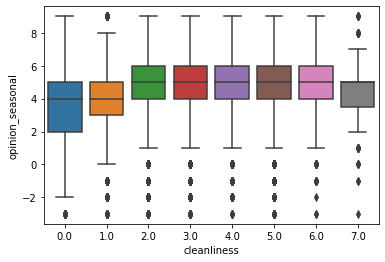

In [42]:
ax = sns.boxplot(x="cleanliness", y="opinion_seasonal", data=data)

Cleanliness and Opinion

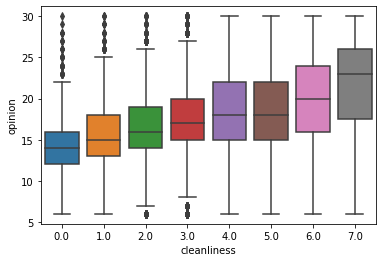

In [43]:
ax = sns.boxplot(x="cleanliness", y="opinion", data=data)

In [44]:
data.shape

(26707, 29)

### A final Correlation Map with our selected features

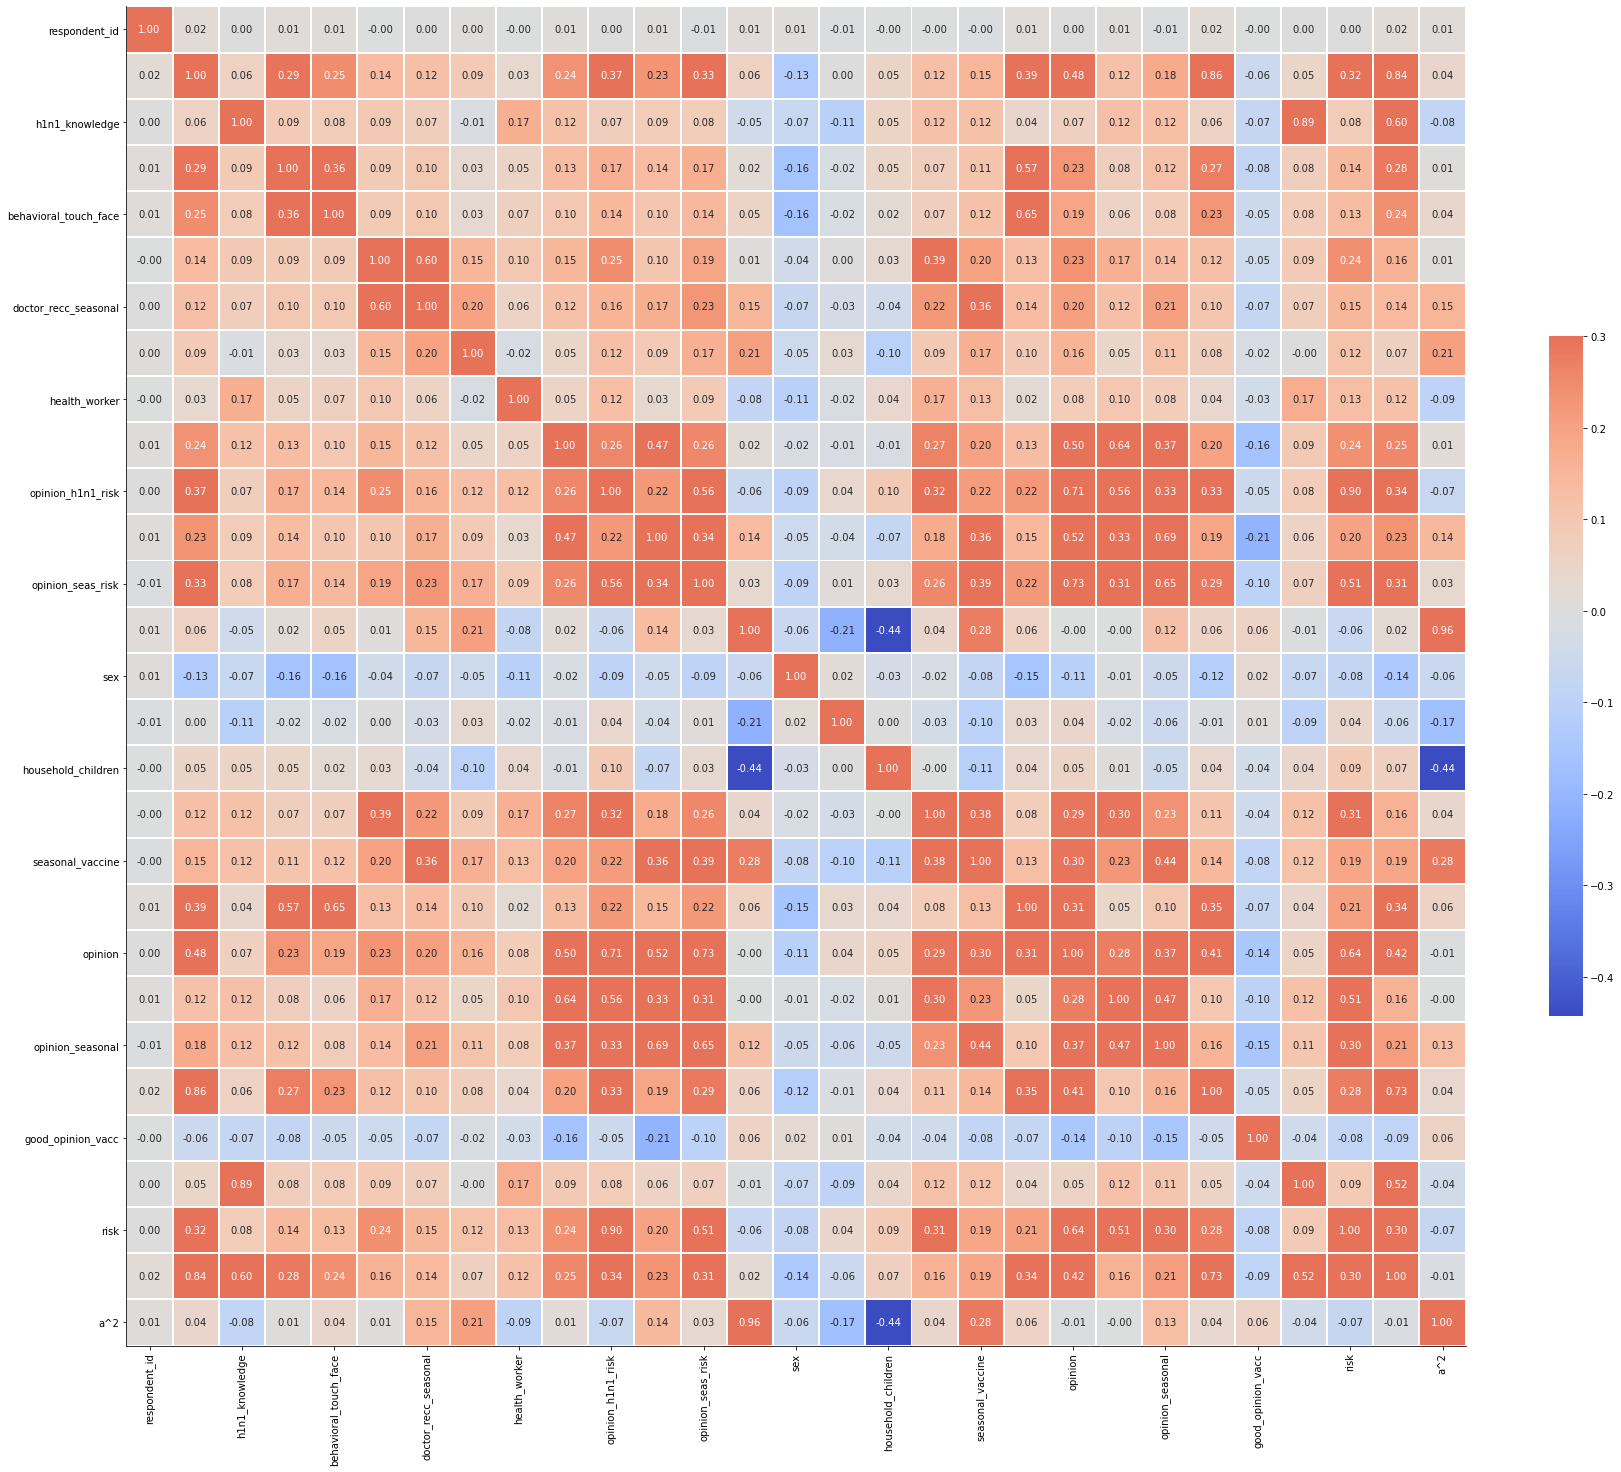

In [45]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

### We now see that the current 26 features are very well/ atleast better correlated with the ground truth labels than the previous Map!!

In [46]:
#### Appending Y labels to the end of the dataframe ####

data.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[data,Y_label]
data = pd.concat(frames,axis=1)

In [47]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,2.0,1.0,0,0,0,0,1.0,9,0,0
1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,...,5.0,2.0,1,0,1,1,5.0,1,0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,...,3.0,3.0,0,0,0,0,2.0,0,0,0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,...,1.0,8.0,0,0,0,0,2.0,16,0,1
4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,...,4.0,0.0,1,1,0,0,3.0,4,0,0


In [48]:
features = data.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


# 5. Data Splitting and Test data processing <a id="split"></a> 

### Choosing 80%, 20% for train and validation

In [49]:
train,test = train_test_split(data,test_size = 0.2,shuffle = True)
train_x,train_y = train[features],train[labels]
test_x,test_y = test[features],test[labels]

In [50]:
train_x.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
2089,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,4.0,...,5.0,26.0,5.0,5.0,1,0,0,1,4.0,9
25904,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,0.0,15.0,4.0,5.0,0,0,1,0,2.0,0
17160,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,...,0.0,17.0,4.0,5.0,1,0,0,0,3.0,1
24940,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,3.0,18.0,0.0,2.0,1,0,0,0,3.0,9
6006,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,...,3.0,18.0,3.0,7.0,1,0,1,0,4.0,16


In [51]:
train_y.head()

,h1n1_vaccine,seasonal_vaccine
2089,1,1
25904,0,0
17160,0,0
24940,0,0
6006,0,1


In [52]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

### A Utility function is defined below which performs the exact same preprocessing, encodings, feature engineering and other transformations (which was done on the train data) on the Test data given to us.

In [53]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

    # All the NULL values are populated with the mode
            
    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    ### LabelEcoding all categorical types #####
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
    LE = LabelEncoder()
    for col in str_cols:
        Test_X[col] = LE.fit_transform(Test_X[col]) # Converts to int64
            
    data = d
    ### Synthesizing two new features cleanliness level of the individual and opinion of vaccine ####
    data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                      data['opinion_h1n1_sick_from_vacc'] 
    data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                      data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

    data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0)
    data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0) # 5 before
    data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
    data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)
    data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']
    data['a^2'] = data['age_group']*data['age_group']
    ###### Dropping other features #########
    data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    Test_X = data
    return Test_X

Loading and transforming test data

In [55]:
Test_X = pd.read_csv('test_set_features.csv')
Test_X.shape

(26708, 36)

In [56]:
Test_X = transform_test(Test_X)

In [57]:
Test_X.isnull().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_wash_hands          0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
age_group                      0
sex                            0
rent_or_own                    0
household_children             0
opinion                        0
cleanliness                    0
opinion_h1n1                   0
opinion_seasonal               0
concern>=2                     0
good_opinion_vacc              0
good_knowledge                 0
risk                           0
concern_knowledge              0
a^2                            0
dtype: int64

Similarity Check!!

In [58]:
Test_X.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'opinion',
       'cleanliness', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [59]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [60]:
Test_X.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,opinion,cleanliness,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,...,14.0,4.0,5.0,5.0,1,0,1,0,4.0,1
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,12.0,0.0,4.0,4.0,0,0,0,0,2.0,0
2,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,...,24.0,5.0,7.0,5.0,1,0,1,1,4.0,9
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,2.0,...,18.0,0.0,4.0,6.0,0,0,0,0,2.0,16
4,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,...,21.0,6.0,3.0,6.0,1,0,0,0,4.0,1


# 6. Analyzing Several Models on the Dataset <a id="models"></a> 

### Model generation

## 6.1 Ensembling with 20 Classifiers and Linear models <a id="ensemble"></a> 

In [62]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier()    
    ]



#split dataset in cross-validation
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['h1n1_vaccine']

#index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, data[features], data['h1n1_vaccine'], cv  = cv_split)
    #print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   

    #save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['h1n1_vaccine'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1

    

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict


Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegressionCV
Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB
Executing  KNeighborsClassifier
Executing  LinearSVC
Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis
Executing  XGBClassifier


,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.835605,0.00753272,1.43614
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.834007,0.00753532,2.78245
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.832722,0.00368809,0.421788
16,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.830388,0.00979369,0.0741357
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.82899,0.00740889,0.0403285
18,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.827281,0.0101556,0.748477
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.825983,0.00874218,1.22353
13,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.821852,0.0396722,1.54015
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.820666,0.00982733,1.38803
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.812617,0.00848185,0.432786


Text(0, 0.5, 'Algorithm')

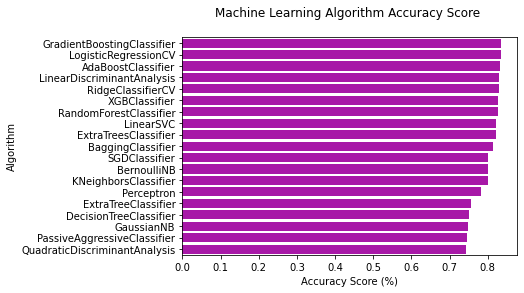

In [63]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [64]:
#Utility Function to print the accuracy of the model 

def find_acc(clf,X,truth,s):
    pred = clf.predict_proba(X.values)
    pred = pred.toarray()
    accuracy = roc_auc_score(truth,pred)
    print(s+" Accuracy is : ",accuracy*100)

<a id="hpo"></a> 
## 6.2 Trying out Hyper Parameter Optimization (HPO) on some Select Models. 

Tried out HPO with 

    1. Grid Search CV
    2. Randomized Search CV

### Check out the model and technique of HPO used in the comments given in each cell

In [65]:
#Random Forest Classifier with Grid Search CV for HPO

from sklearn.model_selection import GridSearchCV
grid_1 = {      "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
gs = GridSearchCV(RF, grid_1, n_jobs=-1, cv=2,verbose = True)

In [69]:
#Training & Performance 
%pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance # type: ignore
clf = BinaryRelevance(classifier=gs, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

     |████████████████████████████████| 89 kB 1.4 MB/s eta 0:00:01
Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  7.6min finished


Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  8.3min finished


Training Accuracy is :  89.01589480877264
Cross Validation Accuracy is :  83.55373572928508


In [70]:
# Random Forest Classifier with Randomized Search CV for HPO

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [15,20,25]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RF
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [71]:
#Training & Performance
clf = BinaryRelevance(classifier=rf_random, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   41.6s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   47.6s finished


Training Accuracy is :  94.58679961669539
Cross Validation Accuracy is :  83.02926034758934


### A sample NN model for reference

In [72]:
#Neural Network based Classifier on Keras sample

def NN_classifier(input_dim,output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25,input_dim=input_dim,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(output_dim,activation = 'softmax')
    ])
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [73]:
from sklearn.model_selection import GridSearchCV
param2 = {
            'learning_rate':     [0.01,0.1],
            'max_depth':         [2,3,4],
            'lambda':            [1.0,1.5],
            'subsample':        [0.1,0.2,0.3],
            'colsample_bytree': [0.3,0.5,0.6],
            'min_split_loss' :  [0.01,0.2],
            'min_split_size' : [2,4,6]
        }
classifier = XGBClassifier(feature_names = features,verbose = False)
xgb = GridSearchCV(classifier, param2, n_jobs=-1, cv=2,verbose = True)

In [74]:
### Training & Performance ###
clf = BinaryRelevance(classifier=xgb, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.9min finished


[11:08:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { feature_names, min_split_size, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.9min finished


[11:11:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { feature_names, min_split_size, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training Accuracy is :  84.82039433491376
Cross Validation Accuracy is :  83.75440418947922


In [75]:
# Random Forest Classifier with Randomized Search CV for HPO

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,3,7,5,15,20,25]
max_depth.append(None)
min_samples_split = [0.2,0.3,0.6,1.2,1.5,2.0,3.0,4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = XGBClassifier(feature_names = features,verbose = False)
etc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [76]:
# Training & Performance
clf = BinaryRelevance(classifier=etc, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


[11:14:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { bootstrap, feature_names, max_features, min_samples_leaf, min_samples_split, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished


[11:16:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { bootstrap, feature_names, max_features, min_samples_leaf, min_samples_split, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training Accuracy is :  85.60562728400602
Cross Validation Accuracy is :  83.81179550783992


In [85]:
%pip install catboost
from catboost import CatBoostClassifier
cb_hps = {  
            'depth':              [2,3,4,5,7],
            'l2_leaf_reg':        [2,3,5,10],
            'random_seed':        [5,8,10],
            'colsample_bylevel': [0.3,0.5,0.6],
            'n_estimators':      [100,200]
        }

cb = CatBoostClassifier()
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

  Using cached catboost-1.2.5.tar.gz (69.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pip/_vendor/pep517/_in_process.py build_wheel /var/folders/jc/vvblv8yd4gv09kx7qdyf5b8r0000gn/T/tmpqhxrbv_t
       cwd: /private/var/folders/jc/vvblv8yd4gv09kx7qdyf5b8r0000gn/T/pip-install-l3x5b90_/catboost
  Complete output (40 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-cpython-38
  creating build/lib.macosx-10.9-x86_64-cpython-38/catboost
  copying catboost/monoforest.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
  copying catboost/plot_helpers.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
  copying catboost

ModuleNotFoundError: No module named 'catboost'

In [86]:
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

NameError: name 'cb' is not defined

In [82]:
### Training & Performance

clf = BinaryRelevance(classifier=cbt, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

NameError: name 'cbt' is not defined

In [ ]:
#### Training a binary relevance classifier for the two labels h1n1 vaccine and seasonal vaccine #####

classifier = CatBoostClassifier(
n_estimators = 300,depth = 5,l2_leaf_reg =0.5,
                                random_seed = 2,colsample_bylevel = 0.9,verbose = False)

In [ ]:
### Training & Performance ###

clf = BinaryRelevance(classifier=classifier, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')